## Code visibility (relevant for HTML only)
Use the Show/Hide Code button on the top left to make to make the code visible or hide it. It will be hidden in the HTML files by default.

# How to use code cells in this notebook
If a code cell starts with 
```python
# RUN
```
Run the cell by CTRL+Enter, or the Run button above.  

If a code cell starts with
```python
# USER INPUT
```
User input is needed before running the cell. Usually there will be a cell preceding this which gives an example for the values to be provided.

If a code cell starts with
```python
# OPTIONAL USER INPUT
```
User input is needed before running the cell. However, some defaults are provided, so make sure that either the settings will work for your run, or change them appropriately.

If a cell starts with
#### Example cell
These cells are not code cells but examples of user inputs from the test data analysis for the actual code cell that follows it, informing the user about the formatting etc.

**Important note on entering input:** When entering user input, please make sure you follow the formatting provided in the example cells. For example, when the parameter is text, make sure you have quotation marks around the parameters but when it is a number, do not enclose in quotes. If it is a list, then provide a list in brackets.

In [1]:
# RUN
import sys
sys.path.append("/opt/src")
import mip_functions as mip
import probe_summary_generator
import pickle
import json
import copy
import os
import numpy as np
import subprocess
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.lines import Line2D
plt.rcParams['svg.fonttype'] = 'none'
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import allel
wdir = "/opt/analysis/"
data_dir = "/opt/data/"

Classes reloading.
functions reloading


#### Example cell
```python

# provide the MIPWrangler output files
# which must be located in the /opt/data directory within the container.
# if more than one run is to be merged, provide all files
info_files = ["test_run_JJJ_DR1_VAR4_20191126.txt.gz"] 

# sample sheets associated with each wrangler file,
# in the same order as the wrangler files.
sample_sheets = ["sample_list.tsv"]

# No input below
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()
```

In [2]:
# USER INPUT

# provide the MIPWrangler output files
# which must be located in the /opt/data directory within the container.
# if more than one run is to be merged, provide all files
info_files = ["test_run_JJJ_DR1_VAR4_20191126.txt.gz"] 

# sample sheets associated with each wrangler file,
# in the same order as the wrangler files.
sample_sheets = ["sample_list.tsv"]

# No input below
info_files = [data_dir + i for i in info_files]
sample_sheets = [data_dir + s for s in sample_sheets]
pd.concat([pd.read_table(s) for s in sample_sheets],
         ignore_index=True).groupby(["sample_set", "probe_set"]).first()

,,sample_name,replicate,fw,rev,owner,Capture Plate Name,Capture Plate Location,Library Prep,Sample Set
sample_set,probe_set,,,,,,,,,
JJJ,"DR1,VAR4",D10,1,93,93,Zack,Plate_1,H9,171025,CTL


The above table shows the unique sample_set, probe_set combinations in the sample sheets provided. Select which combinations should be used for this analysis.

#### Example cell
```python
sample_groups = [["JJJ", "DR1,VAR4"]]
```

If more than one combination is to be used, the input will be a list of lists, for example:
```python
sample_groups = [["sample_set_1", "probe_set_1"], ["sample_set_2", "probe_set_2"]]
```

In [3]:
# USER INPUT
sample_groups = [["JJJ", "DR1,VAR4"]]

### Specify the species and the probe set used
These two are important parameters to determine which files will be used for analysis.  


For the species, the options are: "pf" for *Plasmodium falciparum*, "pv" for *Plasmodium vivax*, "hg19" for *Homo sapiens* genome assembly hg19/GRCh37 and "hg38" for *Homo sapiens* genome assembly hg38/GRCh38  
___
Probe sets also must be specified. Check the output of the sample sheet summary above under **probe_set** field for a reminder of what the probe set of interest is. This is usually a three letter code or codes separated by a comma. 

#### Example cell
```python
species = "pf"
probe_sets_used = "DR1,VAR4"
```

It is also possible to analyse just a subset of probe sets that has been used. For example, if the data has both DR1 and VAR4 probe sets but I want to analyse only the DR1 set:
```python
species = "pf"
probe_sets_used = "DR1"
```
Note that I'd still need to specifiy "DR1,VAR4" in the sample_groups above.

In [4]:
# USER INPUT
species = "pf"
probe_sets_used = "DR1"

#### Example cell
```python
# available cpu count
processorNumber = 20

## extra bwa options for haplotype alignment
# use "-a" for getting all alignments
# use "-L 500" to penalize soft clipping 
# use "-t" to set number of available processors
bwaExtra = ["-t", str(processorNumber)]
```

In [5]:
# OPTIONAL USER INPUT
# available cpu count
processorNumber = 20

## extra bwa options for haplotype alignment
# use "-a" for getting all alignments
# use "-L 500" to penalize soft clipping 
# use "-t" to set number of available processors
bwaExtra = ["-t", str(processorNumber)]

### Get/Set the analysis settings
Use the settings template for the species specified to get the  analysis settings and change the vaules specified in the above cell. This will create a template_settings.txt file in your analysis directory and a settings.txt file to be used for the analysis. These files also will serve as a reference of analysis settings for the sake of reproducibility.

In [6]:
# RUN

# copy the template settings file
temp_settings_file = "/opt/resources/templates/analysis_settings_templates/settings.txt"
subprocess.call(["scp", temp_settings_file, "/opt/analysis/template_settings.txt"])

# extract the settings template
temp_settings = mip.get_analysis_settings("/opt/analysis/template_settings.txt")

# update bwa settings with the options set above
bwaOptions = temp_settings["bwaOptions"]
try:
    bwaOptions.extend(bwaExtra)
except AttributeError:
    bwaOptions = [bwaOptions]
    bwaOptions.extend(bwaExtra)

# Create a list from the probe_sets string
mipSetKey = probe_sets_used.split(",") + [""]

# create a dictionary for which settings should be updated
# using the user specified parameters.
update_keys = {"processorNumber": processorNumber,
               "bwaOptions": bwaOptions,
               "species": species,
               "mipSetKey" : mipSetKey}
# update the settings
for k, v in update_keys.items():
    temp_settings[k] = v
# create a settings file in the analysis directory.
settings_file = "settings.txt"
settings_path = os.path.join(wdir, settings_file)
mip.write_analysis_settings(temp_settings, settings_path)
settings = mip.get_analysis_settings(wdir + settings_file)
# create probe sets dictionary
mip.update_probe_sets("/opt/project_resources/mip_ids/mipsets.csv",
                     "/opt/project_resources/mip_ids/probe_sets.json")

# 1) Process run data
First section of the data analysis involves processing the MIPWrangler output files, combining data from multiple runs (if necessary), mapping haplotypes and creating summary files and plots showing how the sequencing runs went.

### MIPWrangler output file processing
Below operation combines output files from multiple runs, summing up count data belonging to the same libraries.  

Libraries are labeled by combining three fields in the sample sheet: sample_name-sample_set-replicate, which makes the Sample ID. If two different libraries has the same Sample ID (same three fields, but a different LibraryPrep identifier), the overlapping libraries will be assigned new replicate numbers such that there are no shared IDs any more. A warning will be printed in that case, and the original sample ID and the new one will be written to the samples.tsv file generated in the analysis directory.

If only a single output file is used, then the below operation just filters and renames some columns from the original file.

In [7]:
# RUN
if len(info_files) > 1:
    mip.combine_info_files(wdir,
                           settings_file, 
                           info_files,
                           sample_sheets,
                           settings["mipsterFile"],
                           sample_sets=sample_groups)
else:
    mip.process_info_file(wdir,
                          settings_file, 
                          info_files,
                          sample_sheets,
                          settings["mipsterFile"],
                          sample_sets=sample_groups)

### Filter and map haplotype sequences
Align each haplotype sequence to the reference genome. Remove off target haplotypes. All haplotype mappings will be saved to the disk so off targets can be inspected if needed. 

Some filters can be applied to remove noise:
*  minHaplotypeBarcodes: minimum total UMI cut off across all samples.
*  minHaplotypeSamples: minimum number of samples a haplotype is observed in.
*  minHaplotypeSampleFraction: minimum fraction of samples a haplotype is observed in.  

It is probably safe to apply minimal count filters like at least 10 UMIs across samples and at least two samples. However, most data sets will be easily handled without these filters. So it may be better to not filter at this step unless the downstream operations are taking too much resources. However, filters can and should be applied after variant calls are made.

#### Example cell
```python
# filter haplotype sequences based on the number of total supporting UMIs
settings["minHaplotypeBarcodes"] = 1
# filter haplotype sequences based on the number of samples they were observed in
settings["minHaplotypeSamples"] = 1
# filter haplotype sequences based on the fraction of samples they were observed in
settings["minHaplotypeSampleFraction"] = 0.0001
```

In [8]:
# OPTIONAL USER INPUT
# filter haplotype sequences based on the number of total supporting UMIs
settings["minHaplotypeBarcodes"] = 1
# filter haplotype sequences based on the number of samples they were observed in
settings["minHaplotypeSamples"] = 1
# filter haplotype sequences based on the fraction of samples they were observed in
settings["minHaplotypeSampleFraction"] = 0.0001 

In [9]:
#RUN
mip.get_vcf_haplotypes(settings)
mip.get_haplotype_counts(settings)

Out of 852 initial haplotypes, 0 were filtered using 1, 1, and 0.0001 as minimum total UMI count; number and fraction of samples  the haplotype was observed in, respectively.
4 of 849 haplotypes were off-target, either not mapping to the reference genome, or best mapping to a region which was not targeted.
Total number of reads and barcodes were 297935 and 108194. On target number of reads and barcodes were 297914 and 108187.
There are 51 samples with sequence data
There are 56 total samples.
5 out of 56 samples had no data and they were excluded from the variant calls.


### Preview the mapping results
Plotting the probe coverage by samples is a good  way to see overall experiment perfomance. It shows if a probe has at least 1 barcode (or however many is specified below) for a given sample.  

Dark columns point to poor performing probes whereas dark rows indicate poor samples. Note that this excludes samples with no reads at all. Use "all_barcode_counts.csv" file if those are of interest as well.

Some parameters can be supplied to the plotting function as noted in the comments.

In [10]:
# OPTIONAL USER INPUT

# coverage filter: anything below this number will be considered absent
barcode_threshold = 10
# font size for tick labels for x and y axis
tick_label_size=5
# font size for heat map color bar
cbar_label_size=5
# figure resolution
dpi=300
# present/absent colors
absent_color='black'
present_color='green'
# Save the plot in the analysis directory?
# If false, plots the graph here.
save=False
# How frequent the x and y-axis ticks should be
# every nth column will have  a tick
ytick_freq=None
xtick_freq=None
# rotation of xtick labels
xtick_rotation=90

(<Figure size 1800x1200 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd91d7ce358>)

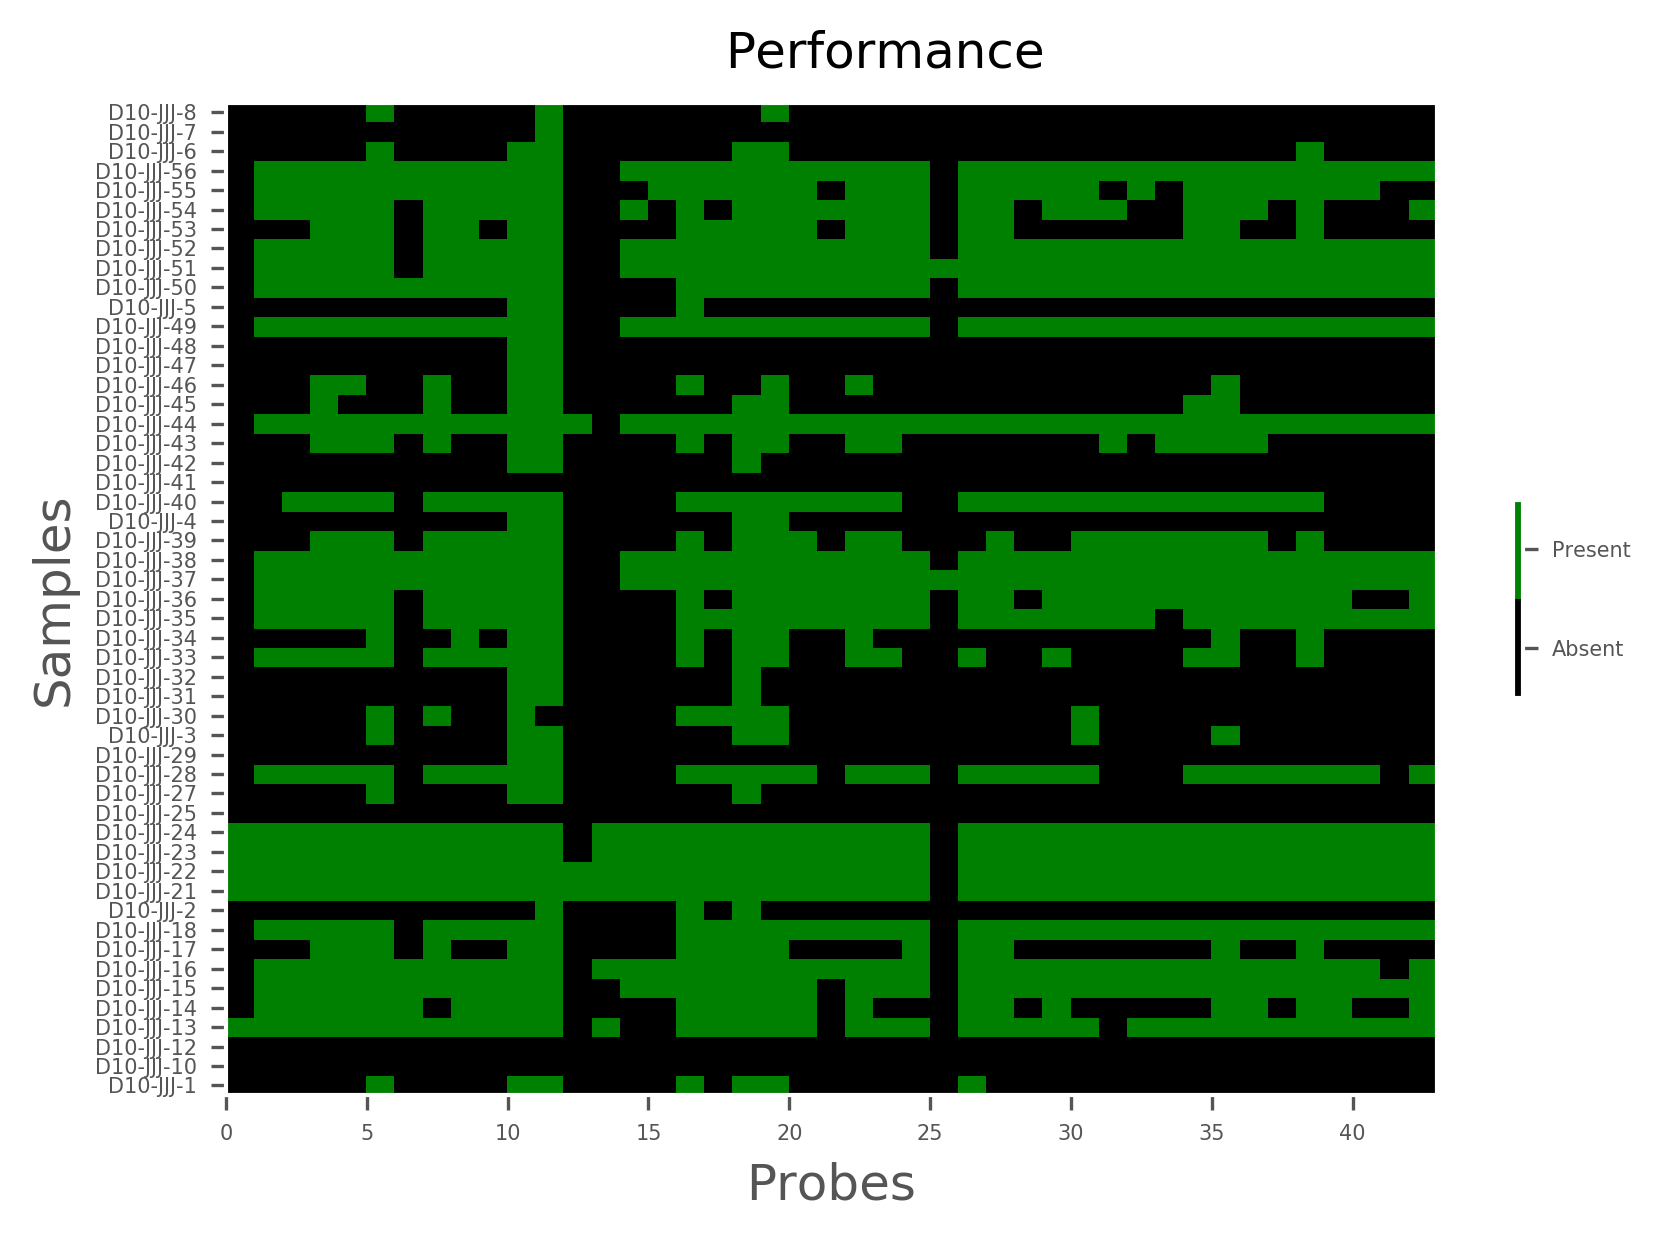

In [11]:
# OPTIONAL USER INPUT
barcode_counts = pd.read_csv(wdir + "barcode_counts.csv",
             header = [0,1], index_col = 0)
mip.plot_performance(barcode_counts,
                     barcode_threshold=barcode_threshold,
                     tick_label_size=tick_label_size,
                     cbar_label_size=cbar_label_size,
                     dpi=dpi,
                     absent_color=absent_color,
                     present_color=present_color,
                     save=save,
                     ytick_freq=ytick_freq,
                     xtick_freq=xtick_freq,
                     xtick_rotation=xtick_rotation)

### Look at summary stats 
There are summary statistics and meta data (if provided) we can use to determine if coverage is enough, whether further sequencing is necessary, and how to proceed if further sequencing will be needed.

In [12]:
# RUN
sample_summary = pd.read_csv(wdir + "sample_summary.csv")
sample_summary.head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes
0,D10-JJJ-1,538.0,223.0,36,19,7
1,D10-JJJ-10,1.0,1.0,1,0,0
2,D10-JJJ-12,11.0,3.0,3,0,0
3,D10-JJJ-13,3411.0,2103.0,42,42,37
4,D10-JJJ-14,1088.0,952.0,42,35,24


### Plot total barcode count vs probe coverage
A scatter plot of total barcode count vs number of probes covered at a certain barcode count is a good way to see how the relationship between total coverage and probe coverage, which is useful in determining how to proceed to the next experiments or analyses.

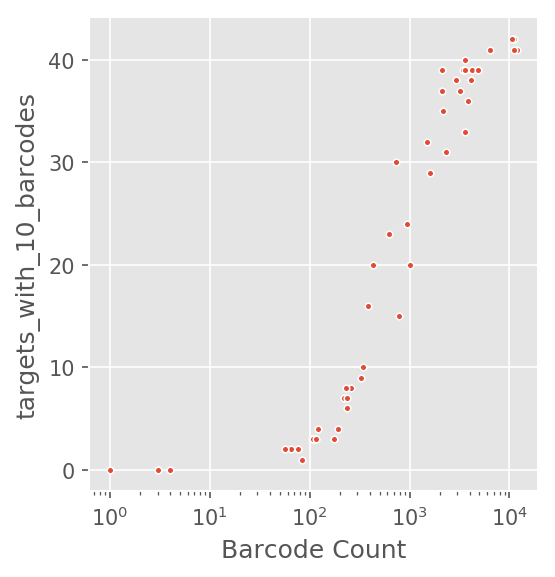

In [13]:
# RUN
f = sns.pairplot(data = sample_summary,
                x_vars = "Barcode Count",
                y_vars = "targets_with_10_barcodes",
                plot_kws={"s": 10})
f.fig.set_size_inches(5,5)
f.fig.set_dpi(150)
f.fig.axes[0].set_xscale("log")

### Repooling capture reactions for further sequencing. Factors to consider:
1. What do you we want to accomplish? In most cases, we would like to get enough coverage for a number of probes for each sample. For example, the test data contains **50 probes** in total. Let's say it is sufficient if we had a coverage of **10** or more for each probe for a sample. Then, we would not want to sequence any more of that sample. 
```python
target_coverage_count = 50
target_coverage_key='targets_with_10_barcodes'
```
Alternatively, we can set a goal of a fraction of total probes to reach a certain coverage rather than an absolute number of probes. For 95% of the maximum number of probes observed (47 in this case): 
```python
target_coverage_fraction = 0.95
target_coverage_key='targets_with_10_barcodes'
```
Although we set our goal to 47 probes, it is likely that some sample will never reach that number regardless of how much we sequence, if there is a deletion in the region, for example. So it makes sense to set a total coverage threshold after which we don't expect more data. Looking at the plot above, it seems like after 1000 barcode counts, we would reach our goal for most samples. 
```python
high_barcode_threshold = 10000
```
Another metric to use for determining if we want to sequence a sample more is the average read count per barcode count. This value indicates we have sequenced each unique molecular index in our sample so many times, so when the value is high, it is unlikely that we'd get more UMIs by sequencing the same library more. It makes more sense for a fresh MIP capture from these samples if more data is needed.
```python
barcode_coverage_threshold=10
```
Some samples perform very poorly for one reason or another. There are two options for these samples for repooling consideration: 1) Repool as much as we can for the next run, 2) Assuming there is a problem in the capture reaction, set up a new MIP capture reaction for these samples. It makes more sense to use option 1 if this is the first sequencing data using this library. Use option 2 if this library have been repooled at a higher volume already, but still producing poor data.
```python
barcode_count_threshold=100 # samples below total barcode count of this value is considered low coverage
low_coverage_action='Repool' # what to do for low coverage samples (Repool or Recapture)
```
Sometimes a handful of samples show uneven coverage of loci, i.e. they have very good coverage of a handful of loci but poor coverage in others, which may point to a problem with the sample or the experiment in general. These samples are determined by comparing the subset of samples that reached the goal we set (completed samples) and those that have not. We look at the number of barcodes per probe for _completed_ samples and get 25th percentile (or other percentile as set) and assume that if a sample on average has this many barcodes per target, it should have reached the set goal. For example, if on average _completed_ samples, i.e. samples that cover 47 probes at 10 barcodes or more, have 10000 total barcodes, they would have ~200 (10000/47) barcodes per target covered. And if an _incomplete_ sample has 5000 total barcodes and only 10 targets covered, this value would be 500 for that sample and it would be flagged as **uneven coverage** in repooling document.
```python
assesment_key='targets_with_1_barcodes' # coverage key to compare "complete" and "incomplete" samples
good_coverage_quantile=0.25 # percentile to set the threshold
```

#### Example cell
```python
high_barcode_threshold = 10000
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key = 'targets_with_10_barcodes'
barcode_coverage_threshold = 10
barcode_count_threshold = 100
low_coverage_action = 'Recapture'
assesment_key = 'targets_with_1_barcodes'
good_coverage_quantile = 0.25
```

In [14]:
# USER INPUT
high_barcode_threshold = 10000
low_coverage_action = "Repool"

In [15]:
# OPTIONAL USER INPUT
target_coverage_count = None
target_coverage_fraction = 0.95
target_coverage_key = 'targets_with_10_barcodes'
barcode_coverage_threshold = 10
barcode_count_threshold = 100
assesment_key = 'targets_with_1_barcodes'
good_coverage_quantile = 0.25

In [16]:
# RUN
meta = pd.read_csv(wdir + "run_meta.csv")
data_summary = pd.merge(sample_summary, meta)
mip.repool(wdir, 
           data_summary, 
           high_barcode_threshold, 
           target_coverage_count=target_coverage_count, 
           target_coverage_fraction=target_coverage_fraction, 
           target_coverage_key=target_coverage_key,
           barcode_coverage_threshold=barcode_coverage_threshold,
           barcode_count_threshold=barcode_count_threshold, 
           low_coverage_action=low_coverage_action,
           assesment_key=assesment_key,
           good_coverage_quantile=good_coverage_quantile,
           output_file='repool.csv')

Out of 51 samples 6 are completed, 0 will be recaptured and 45 repooled
0 samples showed uneven coverage, 0 complete, 0 to be recaptured, 0 repooled


### Inspect the repool document
Library to completion field in the repool document has the value (volume) of how much from a sample should be pooled for re-sequencing. These values are only rough estimates and care should be taken to make sure there will be enough material to sequence.

In [17]:
# RUN
pd.read_csv(wdir + "repool.csv").head()

,Sample ID,Read Count,Barcode Count,targets_with_1_barcodes,targets_with_5_barcodes,targets_with_10_barcodes,Unnamed: 0,Library Prep,sample_name,probe_set,...,sample_set,Original SID,Sample Name,total_barcode_count,total_read_count,Status,Barcode Coverage,Library to Completion,Barcodes Per Target Covered,Uneven Coverage
0,D10-JJJ-1,538.0,223.0,36,19,7,0,171025,D10,"DR1,VAR4",...,JJJ,D10-JJJ-1,D10,223.0,538.0,Repool,2.412556,43.843049,31.857143,False
1,D10-JJJ-10,1.0,1.0,1,0,0,1,171025,D10,"DR1,VAR4",...,JJJ,D10-JJJ-10,D10,1.0,1.0,Repool,1.000000,9999.000000,NaN,False
2,D10-JJJ-12,11.0,3.0,3,0,0,3,171025,D10,"DR1,VAR4",...,JJJ,D10-JJJ-12,D10,3.0,11.0,Repool,3.666667,3332.333333,NaN,False
3,D10-JJJ-13,3411.0,2103.0,42,42,37,4,171025,D10,"DR1,VAR4",...,JJJ,D10-JJJ-13,D10,2103.0,3411.0,Repool,1.621969,3.755112,56.837838,False
4,D10-JJJ-14,1088.0,952.0,42,35,24,5,171025,D10,"DR1,VAR4",...,JJJ,D10-JJJ-14,D10,952.0,1088.0,Repool,1.142857,9.504202,39.666667,False


# 2) Variant Calling
Second part of the analysis involves variant calling and variant analysis. 

### Options for freebayes wrapper
```Python
align = True # Default is set to true, fastq files and bam files per sample
# will be created in 'fastq_dir' and 'bam_dir'. 
# it should be set to false if bam files are available.

settings = settings # analysis settings dictionary created above.

bam_files = None # default is to use all bam files within the bam_dir.
# if specific files should be used, then they can be specified in a list.

verbose = True # prints errors and warnings as well as saving to disk.
# if set to false, it will print that there is an error which will
# be saved to disk which should be inspected for details.

targets_file = None # force calls on specific loci even if there is
# no observations satisfying filter criteria. Useful in cases of targeted
# mutations such as drug resistance mutations.
# Usually a file at "/opt/project_resources/targets.tsv" would be present
# if the project requires it. Then targets_file should be set to this path.

# paths for input-output files with default values that can be left unchanged
fastq_dir, bam_dir, vcf_file, settings_file, errors_file, warnings_file

# additional options to pass to freebayes directly:
options = [] # see below for suggestions and possibilities.
```
#### Additional options for freebayes caller. 
Most of the freebayes options are shown below in the **freebayes help** section at the bottom of this document. Some options are integrated into the python wrapper freebayes_call, but others should be added depending on the data type, species etc.

integrated options:
```bash
    -r region
            limit calls to a specific region. 
            This is done internally, splitting the results into contigs and processing each contig
            separately (in parallel if multiple cpus are available).
            Per-contig vcf files are concatenated at the end into a single file.
    -@ targets.vcf
            force calls on positions provided in the vcf file
            a vcf file is generated if a tab separated file containing targets are provided.
    -L --bam-list
            a list of bam files to be used. By default, all bams in bams directory will be used.
            A list of specific bams can be specified to freebayes_call as bam_files option.
```
options to consider adding for parasite sequencing:
```bash
    --pooled-continuous
             This option does not make assumptions about the ploidy when making genotype calls.
             It makes sense for a mixed ploidy sample such as parasite infected blood DNA.
             variants are still called as diploid. 
    --min-alternate-fraction 0.01
             since we assume a pooled continuous sample, it would be better to set a within
             samlpe allele frequency threshold to remove noise. 
             this is likely not needed when dealing with a diploid sample because a frequency 
             of 0.01 will likely be considered noise for a diploid sample.
    --min-alternate-count 2
             number of reads supporting a variant to consider for genotype calls.
             having this at at least 2 is good. It will be possible to process
             variants with 1 reads in postprocessing steps if a specific variant
             is observed at least in one sample at > 1 reads. So this removes the 
             variant from consideration if no sample has > 1 reads supporting it.
    --min-alternate-total 10
             total read support for a variant across samples.
```
options to consider for human sequences:
```bash
    --min-mapping-quality 0
             default for this setting is 1. I do not think this is helping much in 
             addressing mapping issues. However, reads in copy number variant regions
             may have 0 mapping quality. These would be worth to keep, but they
             should be handled appropriately at postprocessing steps.
    --min-alternate-count 2
    --min-alternate-fraction 0.05 (default)
    --min-alternate-total 10
```

####  Example cell
```python
# provide freebayes options.
# These will be directy passed to freebayes
options = ["--pooled-continuous",
           "--min-alternate-fraction", "0.01",
           "--min-alternate-count", "2",
           "--min-alternate-total", "10"]
```

In [18]:
# USER INPUT

# provide freebayes options.
# These will be directy passed to freebayes
options = ["--pooled-continuous",
           "--min-alternate-fraction", "0.01",
           "--min-alternate-count", "2",
           "--min-alternate-total", "10"]

In [19]:
# OPTIONAL USER INPUT

align=True
verbose=True
# where to save generated fastq files
fastq_dir="/opt/analysis/padded_fastqs"
# where to save generated bam files
bam_dir="/opt/analysis/padded_bams"
# where to save the output vcf file
vcf_file="/opt/analysis/variants.vcf.gz"
# where is the targeted variants file
targets_file="/opt/project_resources/targets.tsv"
# where to save errors and warnings generated by freebayes
errors_file="/opt/analysis/freebayes_errors.txt"
warnings_file="/opt/analysis/freebayes_warnings.txt"

In [20]:
# RUN
r = mip.freebayes_call(
        settings=settings,
        options=options,
        align=align,
        verbose=verbose,
        fastq_dir=fastq_dir,
        bam_dir=bam_dir,
        vcf_file=vcf_file,
        targets_file=targets_file,
        bam_files=None,
        errors_file=errors_file,
        warnings_file=warnings_file)

The above cell should create the vcf file variants.vcf.gz in the analysis directory (assuming the vcf_file parameter was not changed).  

We can annotate it using snpEff by running the following cell. However, this is not necessary if postprocessing steps described later will be carried out.

In [21]:
# RUN
annotated_vcf = "ann." + vcf_file.split("/")[-1]
annotated_vcf = os.path.join(wdir, annotated_vcf)
res = mip.annotate_vcf_file(settings, vcf_file=vcf_file,
                            annotated_vcf_file=annotated_vcf)

### Postprocessing of called variants
Freebayes produces high quality vcf files with haplotype based variant calls. This is important for getting more accurate calls, especially for complex regions where SNVs may overlap with indels and there may be many possible alleles as opposed to a simple biallelic SNV call.

However, it may be desired to "decompose" these complex variants for some applications. For example, if we are interested in knowing the prevalence of a specific drug resistance mutation, it would make sense to combine all variants containing this mutation even though they may be part of different haplotypes, and hence are represented in the vcf in different variants.

vcf_to_tables function takes the vcf file generated by freebayes and generates allele count and coverage data in table form. It is possible to decompose and aggregate amino acid and/or nucleotide level variants. 3 files containing count data are generated: alternate_table.csv, reference_table.csv, coverage_table.csv, for alt allele, ref allele and coverage count values for each variant, respectively.

It first separates the multiallelic calls to bi-allelic calls.

#### annotate, default=True
It then annotates variants using snpEff.

#### geneid_to_genename, default=None
Variant annotation provides a gene ID (e.g. PF3D7_0709000) but it does not provide common gene names (e.g. crt). If common names are used in target files, or they are desired in general, a tab separated gene ID to gene name file can be used. **gene_name and gene_id** columns are required. If no file is provided, gene name will be the same as the gene ID.

#### aggregate_aminoacids, default=False
If aminoacid level aggregation is requested, it decomposes multi amino acid missense variants into single components and aggregates the alternate allele and coverage counts per amino acid change. For example, Asn75Glu change for crt gene is a known drug resistance mutation in Plasmodium falciparum. There may be 3 separate variants in the vcf file that contain this mutation: Asn75Glu, MetAsn75IleGlu, Asn75Glu_del76-80*. All three has the missense variant Asn75Glu. While the first two  are simple changes, the third is a complex change including a 5 amino acid deletion and a stop codon following Asn75Glu. In this case, it makes sense to combine the counts of the first two variants towards Asn75Glu counts but the third one is debatable because of the complexity; i.e. the drug resistance mutation Asn75Glu probably is not that improtant in that context because of the stop codon following it. So we decompose the simple changes and aggregate but leave complex changes as they are. If aminoacid aggregation is carried out, file names will contain AA tag.

#### target_aa_annotation, default=None
It is also possible to annotate the targeted variants (such as Asn75Glu above) in the generated tables as 'Targeted' in case some analysis should be carried out on targeted variants only. A tab separated file containing the annotation details is required for this operation. **gene_name, aminoacid_change and mutation_name** are required fields. If a variants gene_name and aminoacid_change are matching to a row in the target file, that variant will be marked as targeted and will have the correspondign mutation name. Note that if common gene name conversion (see above) is not used, the gene_name column in this file must match the actual gene ID and not the common name. It may be more convenient to keep the gene IDs in the target file as well and use that file for ID to name mapping. **aggregate_aminoacids must be set to True** for this option to be used.

#### aggregate_nucleotides, default=False
A similar aggregation can be done at nucleotide level. If specified, biallelic variants will be decomposed using the tool **vt decompose_blocksub**. By default it decomposes block substitutions that do not include indels. However, it is also possible to decompose complex variants including indels by providing -a option. For possible decompose options see vt help:
```bash
vt decompose_blocksub options : 
  -p  Output phased genotypes and PS tags for decomposed variants [false]
  -m  keep MNVs (multi-nucleotide variants) [false]
  -a  enable aggressive/alignment mode [false]
  -d  MNVs max distance (when -m option is used) [2]
  -o  output VCF file [-]
  -I  file containing list of intervals []
  -i  intervals []
  -?  displays help
```
If nucleotide level aggregation is done, the file names will include AN tag.

#### target_nt_annotation, default=None
Annotation of targeted nucleotides requires a file similar to the targeted amino acid annotation. However, the required fields for this annotation are: CHROM, POS, REF, ALT and mutation_name. **aggregate_nucleotides must be set to True** for this option to be used.

#### aggregate_none, default=True
It is also possible to generate count tables without doing any aggregation. This will generate the 3 count files, and all of the variant information included in the vcf file will be a separate column in the table's index. For annotated initial vcf files, or if annotate option is selected, each subfield in the INFO/ANN field will have its own column.

#### min_site_qual, default=-1
Filter variant sites for a minimum QUAL value assigned by the variant caller. This value is described in freebayes manual as:
```bash
Of primary interest to most users is the QUAL field, which estimates the probability that there is a polymorphism at the loci described by the record. In freebayes, this value can be understood as 1 - P(locus is homozygous given the data). It is recommended that users use this value to filter their results, rather than accepting anything output by freebayes as ground truth.

By default, records are output even if they have very low probability of variation, in expectation that the VCF will be filtered using tools such as vcffilter in vcflib, which is also included in the repository under vcflib/. For instance,

freebayes -f ref.fa aln.bam | vcffilter -f "QUAL > 20" >results.vcf

removes any sites with estimated probability of not being polymorphic less than phred 20 (aka 0.01), or probability of polymorphism > 0.99.

In simulation, the receiver-operator characteristic (ROC) tends to have a very sharp inflection between Q1 and Q30, depending on input data characteristics, and a filter setting in this range should provide decent performance. Users are encouraged to examine their output and both variants which are retained and those they filter out. Most problems tend to occur in low-depth areas, and so users may wish to remove these as well, which can also be done by filtering on the DP flag.
```
Therefore, a **minimum of 1** should be used as a min_site_qual to remove low quality sites. If a site is annotated as **targeted**, the site will be kept regardless of its qual value, however, the alternate observation counts for the site may be reset to zero depending on the min_target_site_qual value described below.

#### min_target_site_qual, default=-1
If a variant site is targeted but the site qual is lower than this,
reset the alternate observation counts to 0. It may be best to leave
this at the default value since there is usually additional evidence
that a targeted variant exists in a samples compared to a de novo
variant, i.e. those variants that are targeted had been observed in other samples/studies.

#### Example cell
```python
# provide a file that maps gene names to gene IDs
# this is necessary when targeted variant annotations use
# gene names instead of gene IDs
geneid_to_genename = "/opt/project_resources/geneid_to_genename.tsv"
# annotate targted amino acid changes in the tables.
target_aa_annotation = "/opt/project_resources/targets.tsv"
# decompose multi amino acid changes and combine counts of
# resulting single amino acid changes
aggregate_aminoacids = True
# decompose MNVs and combine counts for resulting SNVs
aggregate_nucleotides = True
# annotate targeted nucleotide changes in the tables.
target_nt_annotation = None
```

In [22]:
# USER INPUT

# provide a file that maps gene names to gene IDs
# this is necessary when targeted variant annotations use
# gene names instead of gene IDs
geneid_to_genename = "/opt/project_resources/geneid_to_genename.tsv"
# annotate targted amino acid changes in the tables.
target_aa_annotation = "/opt/project_resources/targets.tsv"
# decompose multi amino acid changes and combine counts of
# resulting single amino acid changes
aggregate_aminoacids = True
# decompose MNVs and combine counts for resulting SNVs
aggregate_nucleotides = True
# annotate targeted nucleotide changes in the tables.
target_nt_annotation = None

In [23]:
# OPTIONAL USER INPUT

# analysis settings dictionary
settings=settings
# provide the path to the settings file
# if settings dictionary has not been loaded
settings_file=None
# use snpEff to annotate the variants
annotate=True
# additional vt options for decomposing nucleotides.
# Supply ["-a"] to include indels and complex variants
# in decomposition, or other options shown above if desired.
decompose_options=[]
# was the initial vcf file was annotated by snpEff?
annotated_vcf=False
# create tables for variants as they are in the vcf file
# without decomposing compex variants or indels.
# Multiallelic variants will be split into biallelic.
aggregate_none=True
# filter variant sites for quality
min_site_qual=1
# reset targeted variant counts to zero
# when the site quality is below this value
min_target_site_qual=0

In [25]:
# RUN

# input vcf file
vcf_file = vcf_file.split("/")[-1]
mip.vcf_to_tables(
     vcf_file,
     settings=settings,
     settings_file=settings_file,
     annotate=annotate,
     geneid_to_genename=geneid_to_genename,
     target_aa_annotation=target_aa_annotation,
     aggregate_aminoacids=aggregate_aminoacids,
     target_nt_annotation=target_nt_annotation, 
     aggregate_nucleotides=aggregate_nucleotides, 
     decompose_options=decompose_options,
     annotated_vcf=annotated_vcf,
     aggregate_none=aggregate_none,
     min_site_qual=min_site_qual,
     min_target_site_qual=min_target_site_qual)

## Tables created
alternate_XX_table.csv files will contain the ALT allele count for that table type while coverage_XX_table.csv will contain the coverage at each locus.
### Nucleotide changes (aggregated)
For some projects we may be interested in specific single nucleotide changes. For these, it would make sense to decompose multi nucleotide changes and combine counts of the same single nucleotide changes. Two tables will be generated for count and coverage data for aggregated nucleotide changes:  

**alternate_AN_table.csv** file in the analysis directory is created if aggregate_nucleotides option was selected when creating data tables. This table has the UMI counts for each alternate nucleotide.  

**coverage_AN_table.csv** file is the corresponding coverage depth for each variant's position.

### Amino acid changes (aggregated)
For some projects we may be interested in the amino acid changes, particularly specific, targeted amino acid changes, such as drug resistance mutations in *Plasmodium falciparum*, which is the data set provided for pipeline test. For these type of projects, we may want to analyze the variants from the amino acid perspective, rather than nucleotide changes which is standard output for variant callers.  

**alternate_AA_table.csv** file in the analysis directory is created if aggregate_aminoacids option was selected when creating data tables. This table has the UMI counts for each alternate amino acid.  

**coverage_AA_table.csv** file is the corresponding coverage depth for each variant's position.

### Nucleotide changes (not aggregated)
For some projects we may be interested in keeping composite variants as they are called by the pipeline. These will include MNVs, comlplex variants including indels, etc. Two tables will be generated for count and coverage data for original nucleotide changes:  

**alternate_table.csv** file in the analysis directory is created if aggregate_none option was selected when creating data tables. This table has the UMI counts for each alternate nucleotide.  

**coverage_table.csv** file is the corresponding coverage depth for each variant's position.

### Chose which tables to analyse
Select the type of data to analyse. Make sure the count file is matching the coverage file. e.g. alternate_XX_table and coverage_XX_table, XX must be the same value (AA, AN or nothing).

#### Example cell
```python
mutation_count_file = "/opt/analysis/alternate_AA_table.csv"
mutation_coverage_file = "/opt/analysis/coverage_AA_table.csv"
```

In [26]:
# USER INPUT

mutation_count_file = "/opt/analysis/alternate_AA_table.csv"
mutation_coverage_file = "/opt/analysis/coverage_AA_table.csv"

In [27]:
# RUN
mutation_counts = pd.read_csv(mutation_count_file,
                              header=list(range(6)),
                              index_col=0)
mutation_counts.head()

Gene ID          PF3D7_0106300                                    \
Gene                      atp6                                     
Mutation Name   atp6-Ala623Glu   atp6-Glu431Lys   atp6-Gly639Asp   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ala623Glu        Glu431Lys        Gly639Asp   
Targeted                   Yes              Yes               No   
D10-JJJ-23                 0.0              0.0            123.0   
D10-JJJ-3                  0.0              0.0              0.0   
D10-JJJ-43                 0.0              0.0              5.0   
D10-JJJ-46                 0.0              0.0              3.0   
D10-JJJ-49                 0.0              0.0             34.0   

Gene ID                                            PF3D7_0417200  \
Gene                                                     dhfr-ts   
Mutation Name   atp6-Ser466Asn   atp6-Ser769Asn dhfr-ts-Ala16Val   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ser466Asn        Ser769Asn         Ala16Val   
Targeted                    No              Yes              Yes   
D10-JJJ-23                32.0              0.0              0.0   
D10-JJJ-3                  0.0              0.0              0.0   
D10-JJJ-43                 1.0              0.0              0.0   
D10-JJJ-46                 0.0              0.0              0.0   
D10-JJJ-49                11.0              0.0              0.0   

Gene ID                                                            \
Gene                                                                
Mutation Name dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg dhfr-ts-Ile164Leu   
ExonicFunc    missense_variant missense_variant  missense_variant   
AA Change             Asn51Ile         Cys59Arg         Ile164Leu   
Targeted                   Yes              Yes               Yes   
D10-JJJ-23               269.0             58.0               0.0   
D10-JJJ-3                  8.0              0.0               0.0   
D10-JJJ-43                12.0              2.0               0.0   
D10-JJJ-46                 0.0              0.0               0.0   
D10-JJJ-49                76.0             25.0               0.0   

Gene ID                               ...           PF3D7_1447900  \
Gene                                  ...                    mdr2   
Mutation Name dhfr-ts-Ser108Asn       ...          mdr2-Ile492Val   
ExonicFunc     missense_variant       ...        missense_variant   
AA Change             Ser108Asn       ...               Ile492Val   
Targeted                    Yes       ...                      No   
D10-JJJ-23                421.0       ...                    25.0   
D10-JJJ-3                  10.0       ...                     2.0   
D10-JJJ-43                 17.0       ...                     0.0   
D10-JJJ-46                  8.0       ...                     1.0   
D10-JJJ-49                130.0       ...                     7.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name   mdr2-Phe423Tyr   mdr2-Thr484Ile     mdr2-Tyr479Tyr   
ExonicFunc    missense_variant missense_variant synonymous_variant   
AA Change            Phe423Tyr        Thr484Ile          Tyr479Tyr   
Targeted                    No              Yes                 No   
D10-JJJ-23                62.0              8.0               28.0   
D10-JJJ-3                  2.0              0.0                0.0   
D10-JJJ-43                 0.0              0.0                0.0   
D10-JJJ-46                 1.0              0.0                0.0   
D10-JJJ-49                13.0              2.0                4.0   

Gene ID                PF3D7_1451200         mal_mito_3                   \
Gene                   PF3D7-1451200               cytb                    
Mutation Name PF3D7-1451200-Asn71Asn     cytb-Leu230Leu   c

In [28]:
# RUN
mutation_coverage = pd.read_csv(mutation_coverage_file,
                                index_col=0,
                                header=list(range(6)))
mutation_coverage.head()

Gene ID          PF3D7_0106300                                    \
Gene                      atp6                                     
Mutation Name   atp6-Ala623Glu   atp6-Glu431Lys   atp6-Gly639Asp   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ala623Glu        Glu431Lys        Gly639Asp   
Targeted                   Yes              Yes               No   
D10-JJJ-23               608.0            697.0            608.0   
D10-JJJ-3                 11.0              8.0             11.0   
D10-JJJ-43                20.0             30.0             20.0   
D10-JJJ-46                16.0             28.0             16.0   
D10-JJJ-49               201.0            245.0            201.0   

Gene ID                                            PF3D7_0417200  \
Gene                                                     dhfr-ts   
Mutation Name   atp6-Ser466Asn   atp6-Ser769Asn dhfr-ts-Ala16Val   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ser466Asn        Ser769Asn         Ala16Val   
Targeted                    No              Yes              Yes   
D10-JJJ-23               236.0             73.0            637.0   
D10-JJJ-3                  0.0              2.0             12.0   
D10-JJJ-43                 6.0              2.0             24.0   
D10-JJJ-46                 7.0              2.0             16.0   
D10-JJJ-49                80.0             24.0            224.0   

Gene ID                                                            \
Gene                                                                
Mutation Name dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg dhfr-ts-Ile164Leu   
ExonicFunc    missense_variant missense_variant  missense_variant   
AA Change             Asn51Ile         Cys59Arg         Ile164Leu   
Targeted                   Yes              Yes               Yes   
D10-JJJ-23               990.0            990.0              61.0   
D10-JJJ-3                 21.0             21.0               2.0   
D10-JJJ-43                29.0             29.0               7.0   
D10-JJJ-46                22.0             22.0               5.0   
D10-JJJ-49               295.0            295.0              34.0   

Gene ID                               ...           PF3D7_1447900  \
Gene                                  ...                    mdr2   
Mutation Name dhfr-ts-Ser108Asn       ...          mdr2-Ile492Val   
ExonicFunc     missense_variant       ...        missense_variant   
AA Change             Ser108Asn       ...               Ile492Val   
Targeted                    Yes       ...                      No   
D10-JJJ-23               1051.0       ...                   149.0   
D10-JJJ-3                  23.0       ...                     4.0   
D10-JJJ-43                 36.0       ...                     1.0   
D10-JJJ-46                 27.0       ...                     1.0   
D10-JJJ-49                329.0       ...                    39.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name   mdr2-Phe423Tyr   mdr2-Thr484Ile     mdr2-Tyr479Tyr   
ExonicFunc    missense_variant missense_variant synonymous_variant   
AA Change            Phe423Tyr        Thr484Ile          Tyr479Tyr   
Targeted                    No              Yes                 No   
D10-JJJ-23               149.0            149.0              149.0   
D10-JJJ-3                  4.0              4.0                4.0   
D10-JJJ-43                 1.0              1.0                1.0   
D10-JJJ-46                 1.0              1.0                1.0   
D10-JJJ-49                39.0             39.0               39.0   

Gene ID                PF3D7_1451200         mal_mito_3                   \
Gene                   PF3D7-1451200               cytb                    
Mutation Name PF3D7-1451200-Asn71Asn     cytb-Leu230Leu   c

### Call genotypes and prevalences

**Genotypes** for mutations can also be generated in a similar way to the genotypes for variants.  
Possible filters:    
1.  **min_coverage**: how many barcodes are needed to for a genomic position for a sample to reliable call (possible mixed or heterozygous) genotypes. If we set min_coverage = 10, any locus within a sample that is covered below this threshold will have an NA genotype.
2.  **min_count**: if a genomic position have enough coverage, how many barcodes supporting an MUT (non-WT) aminoacid call is needed for a reliable call. If we set min_count = 2, any mutation with an MUT call that has less than 2 barcodes supporting the MUT call will revert to WT.
3.  **min_freq**: a minimum within sample allele frequency threshold to consider a variant valid. If set to 0.01, for example, a variant locus in a sample that is at 0.005 frequency for the MUT allele within the sample, the locus would be called WT, if the within sample AF is between 0.01 and 0.99, it would be considered HET, and if > 0.99, it would be homozygous MUT.

#### Example cell
```python
# filter mutation counts for minimum count parameter
# by setting counts to zero if it is below threshold
min_count = 2
# filter loci without enough coverage by setting
# coverage to zero if it is below threshold
min_coverage = 10
# call genotypes using the minimum within sample
# allele frequency
min_freq = 0
```

In [29]:
# USER INPUT 

# filter mutation counts for minimum count parameter
# by setting counts to zero if it is below threshold
min_count = 2
# filter loci without enough coverage by setting
# coverage to zero if it is below threshold
min_coverage = 10
# call genotypes using the minimum within sample
# allele frequency
min_freq = 0

In [30]:
# RUN

# filter mutation counts for minimum count parameter
# by setting counts to zero if it is below threshold
filtered_mutation_counts = mutation_counts.applymap(
    lambda x: 0 if x < min_count else x)
# filter loci without enough coverage by setting
# coverage to zero if it is below threshold
filtered_mutation_coverage = mutation_coverage.applymap(
    lambda x: 0 if x < min_coverage else x)
# calculate within sample frequency
freq = filtered_mutation_counts / filtered_mutation_coverage
freq.replace(np.inf, np.nan, inplace=True)
# call genotypes using the minimum within sample
# allele frequency parameter from the settings file
genotypes = freq.applymap(
    lambda x: np.nan if (np.isnan(x) or np.isinf(x))
    else 0 if x == 0
    else 0 if x < min_freq
    else 1 if x < (1 - min_freq)
    else 2)
prevalence = freq.applymap(
    lambda x: np.nan if (np.isnan(x) or np.isinf(x))
    else 0 if x == 0
    else 0 if x < min_freq
    else 1)

In [31]:
# RUN
freq.head()

Gene ID          PF3D7_0106300                                    \
Gene                      atp6                                     
Mutation Name   atp6-Ala623Glu   atp6-Glu431Lys   atp6-Gly639Asp   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ala623Glu        Glu431Lys        Gly639Asp   
Targeted                   Yes              Yes               No   
D10-JJJ-23                 0.0              0.0         0.202303   
D10-JJJ-3                  0.0              NaN         0.000000   
D10-JJJ-43                 0.0              0.0         0.250000   
D10-JJJ-46                 0.0              0.0         0.187500   
D10-JJJ-49                 0.0              0.0         0.169154   

Gene ID                                            PF3D7_0417200  \
Gene                                                     dhfr-ts   
Mutation Name   atp6-Ser466Asn   atp6-Ser769Asn dhfr-ts-Ala16Val   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ser466Asn        Ser769Asn         Ala16Val   
Targeted                    No              Yes              Yes   
D10-JJJ-23            0.135593              0.0              0.0   
D10-JJJ-3                  NaN              NaN              0.0   
D10-JJJ-43                 NaN              NaN              0.0   
D10-JJJ-46                 NaN              NaN              0.0   
D10-JJJ-49            0.137500              0.0              0.0   

Gene ID                                                            \
Gene                                                                
Mutation Name dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg dhfr-ts-Ile164Leu   
ExonicFunc    missense_variant missense_variant  missense_variant   
AA Change             Asn51Ile         Cys59Arg         Ile164Leu   
Targeted                   Yes              Yes               Yes   
D10-JJJ-23            0.271717         0.058586               0.0   
D10-JJJ-3             0.380952         0.000000               NaN   
D10-JJJ-43            0.413793         0.068966               NaN   
D10-JJJ-46            0.000000         0.000000               NaN   
D10-JJJ-49            0.257627         0.084746               0.0   

Gene ID                               ...           PF3D7_1447900  \
Gene                                  ...                    mdr2   
Mutation Name dhfr-ts-Ser108Asn       ...          mdr2-Ile492Val   
ExonicFunc     missense_variant       ...        missense_variant   
AA Change             Ser108Asn       ...               Ile492Val   
Targeted                    Yes       ...                      No   
D10-JJJ-23             0.400571       ...                0.167785   
D10-JJJ-3              0.434783       ...                     NaN   
D10-JJJ-43             0.472222       ...                     NaN   
D10-JJJ-46             0.296296       ...                     NaN   
D10-JJJ-49             0.395137       ...                0.179487   

Gene ID                                                             \
Gene                                                                 
Mutation Name   mdr2-Phe423Tyr   mdr2-Thr484Ile     mdr2-Tyr479Tyr   
ExonicFunc    missense_variant missense_variant synonymous_variant   
AA Change            Phe423Tyr        Thr484Ile          Tyr479Tyr   
Targeted                    No              Yes                 No   
D10-JJJ-23            0.416107         0.053691           0.187919   
D10-JJJ-3                  NaN              NaN                NaN   
D10-JJJ-43                 NaN              NaN                NaN   
D10-JJJ-46                 NaN              NaN                NaN   
D10-JJJ-49            0.333333         0.051282           0.102564   

Gene ID                PF3D7_1451200         mal_mito_3                   \
Gene                   PF3D7-1451200               cytb                    
Mutation Name PF3D7-1451200-Asn71Asn     cytb-Leu230Leu   c

In [32]:
# RUN
genotypes.head()

Gene ID          PF3D7_0106300                                    \
Gene                      atp6                                     
Mutation Name   atp6-Ala623Glu   atp6-Glu431Lys   atp6-Gly639Asp   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ala623Glu        Glu431Lys        Gly639Asp   
Targeted                   Yes              Yes               No   
D10-JJJ-23                 0.0              0.0              1.0   
D10-JJJ-3                  0.0              NaN              0.0   
D10-JJJ-43                 0.0              0.0              1.0   
D10-JJJ-46                 0.0              0.0              1.0   
D10-JJJ-49                 0.0              0.0              1.0   

Gene ID                                            PF3D7_0417200  \
Gene                                                     dhfr-ts   
Mutation Name   atp6-Ser466Asn   atp6-Ser769Asn dhfr-ts-Ala16Val   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ser466Asn        Ser769Asn         Ala16Val   
Targeted                    No              Yes              Yes   
D10-JJJ-23                 1.0              0.0              0.0   
D10-JJJ-3                  NaN              NaN              0.0   
D10-JJJ-43                 NaN              NaN              0.0   
D10-JJJ-46                 NaN              NaN              0.0   
D10-JJJ-49                 1.0              0.0              0.0   

Gene ID                                                            \
Gene                                                                
Mutation Name dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg dhfr-ts-Ile164Leu   
ExonicFunc    missense_variant missense_variant  missense_variant   
AA Change             Asn51Ile         Cys59Arg         Ile164Leu   
Targeted                   Yes              Yes               Yes   
D10-JJJ-23                 1.0              1.0               0.0   
D10-JJJ-3                  1.0              0.0               NaN   
D10-JJJ-43                 1.0              1.0               NaN   
D10-JJJ-46                 0.0              0.0               NaN   
D10-JJJ-49                 1.0              1.0               0.0   

Gene ID                               ...           PF3D7_1447900  \
Gene                                  ...                    mdr2   
Mutation Name dhfr-ts-Ser108Asn       ...          mdr2-Ile492Val   
ExonicFunc     missense_variant       ...        missense_variant   
AA Change             Ser108Asn       ...               Ile492Val   
Targeted                    Yes       ...                      No   
D10-JJJ-23                  1.0       ...                     1.0   
D10-JJJ-3                   1.0       ...                     NaN   
D10-JJJ-43                  1.0       ...                     NaN   
D10-JJJ-46                  1.0       ...                     NaN   
D10-JJJ-49                  1.0       ...                     1.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name   mdr2-Phe423Tyr   mdr2-Thr484Ile     mdr2-Tyr479Tyr   
ExonicFunc    missense_variant missense_variant synonymous_variant   
AA Change            Phe423Tyr        Thr484Ile          Tyr479Tyr   
Targeted                    No              Yes                 No   
D10-JJJ-23                 1.0              1.0                1.0   
D10-JJJ-3                  NaN              NaN                NaN   
D10-JJJ-43                 NaN              NaN                NaN   
D10-JJJ-46                 NaN              NaN                NaN   
D10-JJJ-49                 1.0              1.0                1.0   

Gene ID                PF3D7_1451200         mal_mito_3                   \
Gene                   PF3D7-1451200               cytb                    
Mutation Name PF3D7-1451200-Asn71Asn     cytb-Leu230Leu   c

In [33]:
# RUN
prevalence.head()

Gene ID          PF3D7_0106300                                    \
Gene                      atp6                                     
Mutation Name   atp6-Ala623Glu   atp6-Glu431Lys   atp6-Gly639Asp   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ala623Glu        Glu431Lys        Gly639Asp   
Targeted                   Yes              Yes               No   
D10-JJJ-23                 0.0              0.0              1.0   
D10-JJJ-3                  0.0              NaN              0.0   
D10-JJJ-43                 0.0              0.0              1.0   
D10-JJJ-46                 0.0              0.0              1.0   
D10-JJJ-49                 0.0              0.0              1.0   

Gene ID                                            PF3D7_0417200  \
Gene                                                     dhfr-ts   
Mutation Name   atp6-Ser466Asn   atp6-Ser769Asn dhfr-ts-Ala16Val   
ExonicFunc    missense_variant missense_variant missense_variant   
AA Change            Ser466Asn        Ser769Asn         Ala16Val   
Targeted                    No              Yes              Yes   
D10-JJJ-23                 1.0              0.0              0.0   
D10-JJJ-3                  NaN              NaN              0.0   
D10-JJJ-43                 NaN              NaN              0.0   
D10-JJJ-46                 NaN              NaN              0.0   
D10-JJJ-49                 1.0              0.0              0.0   

Gene ID                                                            \
Gene                                                                
Mutation Name dhfr-ts-Asn51Ile dhfr-ts-Cys59Arg dhfr-ts-Ile164Leu   
ExonicFunc    missense_variant missense_variant  missense_variant   
AA Change             Asn51Ile         Cys59Arg         Ile164Leu   
Targeted                   Yes              Yes               Yes   
D10-JJJ-23                 1.0              1.0               0.0   
D10-JJJ-3                  1.0              0.0               NaN   
D10-JJJ-43                 1.0              1.0               NaN   
D10-JJJ-46                 0.0              0.0               NaN   
D10-JJJ-49                 1.0              1.0               0.0   

Gene ID                               ...           PF3D7_1447900  \
Gene                                  ...                    mdr2   
Mutation Name dhfr-ts-Ser108Asn       ...          mdr2-Ile492Val   
ExonicFunc     missense_variant       ...        missense_variant   
AA Change             Ser108Asn       ...               Ile492Val   
Targeted                    Yes       ...                      No   
D10-JJJ-23                  1.0       ...                     1.0   
D10-JJJ-3                   1.0       ...                     NaN   
D10-JJJ-43                  1.0       ...                     NaN   
D10-JJJ-46                  1.0       ...                     NaN   
D10-JJJ-49                  1.0       ...                     1.0   

Gene ID                                                             \
Gene                                                                 
Mutation Name   mdr2-Phe423Tyr   mdr2-Thr484Ile     mdr2-Tyr479Tyr   
ExonicFunc    missense_variant missense_variant synonymous_variant   
AA Change            Phe423Tyr        Thr484Ile          Tyr479Tyr   
Targeted                    No              Yes                 No   
D10-JJJ-23                 1.0              1.0                1.0   
D10-JJJ-3                  NaN              NaN                NaN   
D10-JJJ-43                 NaN              NaN                NaN   
D10-JJJ-46                 NaN              NaN                NaN   
D10-JJJ-49                 1.0              1.0                1.0   

Gene ID                PF3D7_1451200         mal_mito_3                   \
Gene                   PF3D7-1451200               cytb                    
Mutation Name PF3D7-1451200-Asn71Asn     cytb-Leu230Leu   c